<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/PostAnnotation/Notebooks/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install pyLDAvis -qq
!pip install -U jax -qq
!pip install -U gensim -qq
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq
!pip install --upgrade numpy -qq
!pip install --upgrade google-colab numba tensorflow -qq

2023-10-15 22:25:51.934287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 22:25:53.065733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.

# Import


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim import  models
from spacy import displacy

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mounting Gdrive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dir  = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/"
dir_actual = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/dataset/annotators raw CSV/Actual/"

# Dataset prep

In [7]:
mfc = pd.read_csv(f'{dir}dataset/Extracted-News-May5-7/MFC_prepared.csv', usecols=["code_frames", "annotations"], header=0)
mfc.rename(columns = {'annotations':'Text'}, inplace = True)

mfc

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
46794,11.0,Smoking is becoming a social taboo
46795,5.0,Nor does it aid lawyers seeking novel ways to...
46796,15.0,'Ashes to Ashes'
46797,15.0,SMOKE SCREEN IS SEEN BEHIND THE SMOKELESS


In [8]:
ph = pd.read_csv(f'{dir_actual}agreed-PHdataset.csv')
ph.rename(columns = {'Majority-Frame':'code_frames'}, inplace = True)

code_frame_dict_1 = {'1. Economic': 1,
                   '2. Capacity and Resources':2,
                   '3. Morality':3,
                   '4. Fairness and Equality':4,
                   '5. Constitutionality and Jurisprudence':5,
                   '6. Policy Prescription and Evaluation':6,
                   '7. Law and Order, Crime and Justice':7,
                   '8. Security and Defense':8,
                   '9. Health and Safety':9,
                   '10. Quality of Life':10,
                   '11. Cultural Identity':11,
                   '12. Public Opinion':12,
                   '13. Political':13,
                   '14. External Regulation and Reputation':14,
                   '15. Other':15
 }

ph['code_frames'] = ph.code_frames.replace(code_frame_dict_1)


ph

,Text,code_frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4
1,The number of Filipinos against changing the C...,12
2,Jinggoy Estrada calls ICC probers 'white monke...,13
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13
4,The Department of Health (DOH) on Thursday mon...,9
...,...,...
12288,PH diplomat tells China not to question PH-US ...,14
12289,Philippine Ambassador to the United States Jos...,14
12290,China enjoins Asian countries to uphold ‘strat...,14
12291,China wants countries in Asia to “uphold strat...,14


In [9]:
all = pd.concat([mfc, ph], axis=0)

In [10]:
all.dropna()

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
12288,14.0,PH diplomat tells China not to question PH-US ...
12289,14.0,Philippine Ambassador to the United States Jos...
12290,14.0,China enjoins Asian countries to uphold ‘strat...
12291,14.0,China wants countries in Asia to “uphold strat...


In [11]:
# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [12]:
code_frame_dict_toStr = {1: '1. Economic',
                   2: '2. Capacity and Resources',
                   3: '3. Morality',
                   4: '4. Fairness and Equality',
                   5: '5. Constitutionality and Jurisprudence',
                   6: '6. Policy Prescription and Evaluation',
                   7: '7. Law and Order, Crime and Justice',
                   8:'8. Security and Defense',
                   9: '9. Health and Safety',
                   10: '10. Quality of Life',
                   11: '11. Cultural Identity',
                   12: '12. Public Opinion',
                   13:'13. Political',
                   14:'14. External Regulation and Reputation',
                   15: '15. Other'
 }

In [13]:
mfc_str = mfc
ph_str = ph

In [14]:
mfc_str["Source"] = "MFC"
ph_str["Source"] = "PH"

In [15]:
mfc_str.head(10)

,code_frames,Text,Source
0,10.0,Immigrants without HOPE need help entering col...,MFC
1,5.0,"But in the eyes of the law, he is an illegal i...",MFC
2,15.0,"Reaction to Tancredo, Lamm as predicted",MFC
3,13.0,"That, said the congressman, is what always hap...",MFC
4,1.0,"$50,000 per entry",MFC
5,7.0,"If they are illegal and they are working, then...",MFC
6,5.0,HURTADO WINS INS APPEAL IMMIGRANT FROM EL SALV...,MFC
7,11.0,Increase in Latino residents brings anti-immig...,MFC
8,8.0,Mexico's Open Southern Border Lures Migrants H...,MFC
9,9.0,Government officials report that hundreds of i...,MFC


In [16]:
ph_str['Policy_Issue_Frames'] = ph_str.code_frames.replace(code_frame_dict_toStr)
mfc_str['Policy_Issue_Frames'] = mfc_str.code_frames.replace(code_frame_dict_toStr)


In [17]:
# ph_str.to_csv(f'{dir}dataset/final/PH-categorical.csv', index=False)
# mfc_str.to_csv(f'{dir}dataset/final/MFC-categorical.csv', index=False)


In [18]:
ph_str.shape[0]+ mfc_str.shape[0]

59092

In [19]:
combined_categ = pd.concat([ph_str, mfc_str], axis=0, ignore_index=True)
combined_categ

,Text,code_frames,Source,Policy_Issue_Frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4.0,PH,4. Fairness and Equality
1,The number of Filipinos against changing the C...,12.0,PH,12. Public Opinion
2,Jinggoy Estrada calls ICC probers 'white monke...,13.0,PH,13. Political
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13.0,PH,13. Political
4,The Department of Health (DOH) on Thursday mon...,9.0,PH,9. Health and Safety
...,...,...,...,...
59087,Smoking is becoming a social taboo,11.0,MFC,11. Cultural Identity
59088,Nor does it aid lawyers seeking novel ways to...,5.0,MFC,5. Constitutionality and Jurisprudence
59089,'Ashes to Ashes',15.0,MFC,15. Other
59090,SMOKE SCREEN IS SEEN BEHIND THE SMOKELESS,15.0,MFC,15. Other


In [20]:
# combined_categ.to_csv(f'{dir}dataset/final/CombinedAll-categorical.csv', index=False)

# ALL

In [ ]:
import spacy

# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []

# Assuming 'all' is a DataFrame containing the 'Text' column
for doc in nlp.pipe(all['Text']):
    proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

# Display the tokens
print(tokens)


In [ ]:
# Add tokens to new column
all['tokens'] = tokens
all['tokens']

In [ ]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(all['tokens'])
print(dictionary.token2id)

In [ ]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in all['tokens']]

In [ ]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = all['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [ ]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

In [ ]:
#Print topics
lda_model.print_topics(-1)

# Where does a text belong to
lda_model[corpus][0]
all['Text'][0]

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)



In [ ]:
# Save the report
pyLDAvis.save_html(lda_display, f'{dir_actual}lda-index.html')

# PH

In [38]:
from itertools import islice

# Function to display a summary of trigrams
def display_trigram_summary(trigrams):
    summary = list(islice(trigrams, 5))  # Display the first 5 trigrams
    print("Trigram Summary:", summary)


In [39]:
import spacy
from nltk.util import ngrams


# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
stopWords = [] #["phillipine","phillipines", "manila", "Manila", "MANILA"]
tokens = []

# Lemmatize then n-gram
for doc in nlp.pipe(ph['Text']):
    proj_tok = [token.lemma_ for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha and token.lemma_ not in stopWords]
    trigrams = list(ngrams(proj_tok, 3))

    # Convert each trigram tuple to a string representation
    trigrams_strings = [' '.join(trigram) for trigram in trigrams]

    # Append the string representation of trigrams to the 'tokens' list
    tokens.append(trigrams_strings)

    # Display a summary of trigrams for each document
    display_trigram_summary(trigrams_strings)





Streaming output truncated to the last 5000 lines.
Trigram Summary: ['Remulla DOJ look', 'DOJ look red', 'look red flag', 'red flag pattern', 'flag pattern drug']
Trigram Summary: ['MANILA Philippines Congress', 'Philippines Congress seniority', 'Congress seniority require', 'seniority require year', 'require year experience']
Trigram Summary: ['Marcos want presidential', 'want presidential access', 'presidential access West', 'access West Philippine', 'West Philippine Sea']
Trigram Summary: ['day voter registration', 'voter registration barangay', 'registration barangay poll', 'barangay poll draw', 'poll draw sizable']
Trigram Summary: ['MANILA Philippines Heavy', 'Philippines Heavy hang', 'Heavy hang air', 'hang air Quezon', 'air Quezon City']
Trigram Summary: ['DepEd probe cavite', 'probe cavite teacher', 'cavite teacher alleged', 'teacher alleged sex', 'alleged sex abuse']
Trigram Summary: ['Philippines envoy band', 'envoy band support', 'band support Ukraine', 'support Ukraine ind

In [40]:
# Add tokens to new column
ph['tokens'] = tokens
ph['tokens']

0        [Dumagat Remontados oppose, Remontados oppose ...
1        [number Filipinos change, Filipinos change Con...
2        [Jinggoy Estrada call, Estrada call ICC, call ...
3        [President Ferdinand Bongbong, Ferdinand Bongb...
4        [Department Health DOH, Health DOH Thursday, D...
                               ...                        
12288    [PH diplomat tell, diplomat tell China, tell C...
12289    [philippine Ambassador United, Ambassador Unit...
12290    [China enjoin asian, enjoin asian country, asi...
12291    [China want country, want country Asia, countr...
12292    [Public tell remember, tell remember honor, re...
Name: tokens, Length: 12293, dtype: object

In [41]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(ph['tokens'])
# print(dictionary.token2id)

In [42]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in ph['tokens']]

In [ ]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

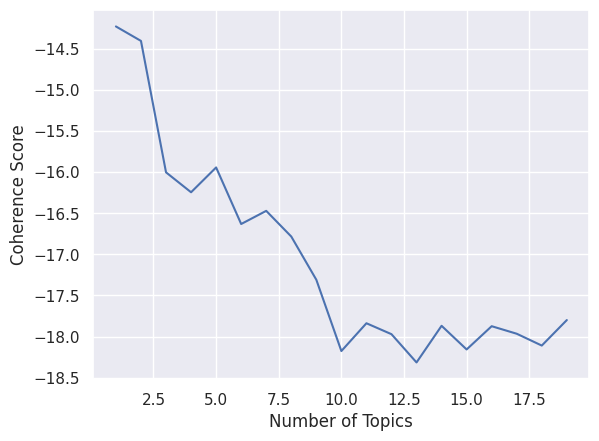

In [43]:
# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [44]:
for x in range(19):
    print(topics[x], score[x])

1 -14.22961913258422
2 -14.405599758479896
3 -16.003289787368093
4 -16.245555503140107
5 -15.94374848448268
6 -16.631438292316304
7 -16.47162263748266
8 -16.78390096617384
9 -17.309236405578222
10 -18.1759348516479
11 -17.837974231883653
12 -17.970939289042686
13 -18.314564248313406
14 -17.8690464094413
15 -18.1565888463254
16 -17.87392187650756
17 -17.9654974490967
18 -18.109358959831457
19 -17.799183634494625


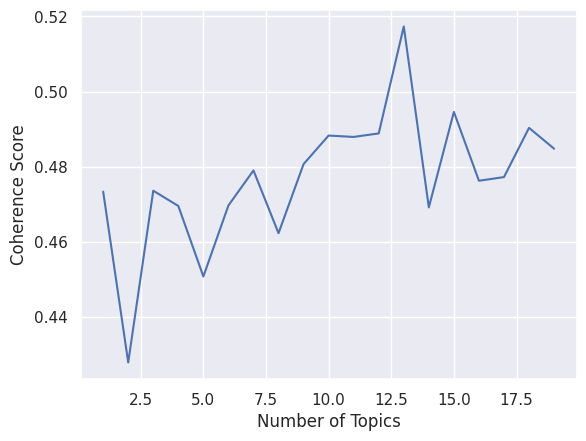

In [45]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = ph['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [46]:
for x in range(19):
    print(topics[x], score[x])


1 0.47332881249368475
2 0.42782374398089373
3 0.4735843561052322
4 0.4695128387798202
5 0.45073445421747316
6 0.46964903629276594
7 0.47898181369235415
8 0.4622601888629467
9 0.48067654474537197
10 0.48827403083084747
11 0.48791480172847235
12 0.488845065848186
13 0.517345534209542
14 0.46913005970809923
15 0.49457685941216123
16 0.4762360988706086
17 0.47721137230978394
18 0.4903263005668601
19 0.4847744494016717


 c_umass = 13 no lower

In [47]:
# Optimal model
lda_model_cumass = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=13, workers = 4, passes=100)

In [48]:
# lda_model_cumass.save(datapath(f'{dir_actual}lda_model_cumass'))
lda_model_cumass = models.ldamodel.LdaModel.load(datapath(f'{dir_actual}lda_model_cumass'))

In [22]:
#Print topics
lda_model_cumass.print_topics(-1)

[(0,
  '0.056*"South China Sea" + 0.051*"Commission Elections Comelec" + 0.040*"Social Welfare Development" + 0.039*"Department Social Welfare" + 0.036*"Welfare Development DSWD" + 0.032*"overseas filipino worker" + 0.030*"filipino worker ofw" + 0.028*"weather bureau say" + 0.023*"manila Commission Elections" + 0.022*"Barangay Sangguniang Kabataan"'),
 (1,
  '0.156*"Philippine National Police" + 0.132*"National Police PNP" + 0.039*"Department Foreign Affairs" + 0.036*"Foreign Affairs DFA" + 0.033*"manila Philippine National" + 0.025*"Police PNP chief" + 0.024*"Philippine Charity Sweepstakes" + 0.023*"Charity Sweepstakes Office" + 0.022*"Sweepstakes Office PCSO" + 0.015*"Percy Lapid Mabasa"'),
 (2,
  '0.077*"President Ferdinand Marcos" + 0.057*"Philippines President Ferdinand" + 0.053*"MANILA Philippines President" + 0.040*"isolated rain shower" + 0.028*"Department Agriculture DA" + 0.021*"weather isolated rain" + 0.017*"MANILA Philippines philippine" + 0.017*"weather bureau say" + 0.01

In [49]:
# Where does a text belong to
lda_model_cumass[corpus][0]
ph['Text'][0]

'Dumagat-Remontados opposed to Kaliwa Dam urge NCIP to defend their rights'

In [50]:
# Visualize topics
lda_display_cumass = pyLDAvis.gensim_models.prepare(lda_model_cumass, corpus, dictionary)
pyLDAvis.display(lda_display_cumass)

In [51]:
# Save the report
pyLDAvis.save_html(lda_display_cumass, f'{dir_actual}lda-ph-trigram-cumass.html')

trigram c_v = 13 no lower


In [ ]:
lda_model_cv = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=13, workers = 4, passes=100)

In [25]:

# lda_model_cv.save(datapath(f'{dir_actual}lda_model_cv'))
lda_model_cv = models.ldamodel.LdaModel.load(datapath(f'{dir_actual}lda_model_cv'))


In [26]:
#Print topics
lda_model_cv.print_topics(-1)

[(0,
  '0.113*"Ferdinand Bongbong Marcos" + 0.095*"President Ferdinand Bongbong" + 0.032*"Geophysical Astronomical Services" + 0.032*"Astronomical Services Administration" + 0.032*"Atmospheric Geophysical Astronomical" + 0.032*"Services Administration PAGASA" + 0.032*"Philippine Atmospheric Geophysical" + 0.030*"West Philippine Sea" + 0.028*"weather bureau say" + 0.027*"Department Foreign Affairs"'),
 (1,
  '0.120*"Department Health DOH" + 0.026*"Negros Oriental Representative" + 0.025*"Health DOH say" + 0.024*"Oriental Representative Arnolfo" + 0.023*"Representative Arnolfo Arnie" + 0.022*"case active tally" + 0.021*"new case active" + 0.021*"Department Budget Management" + 0.019*"MANILA Philippines Department" + 0.018*"Budget Management DBM"'),
 (2,
  '0.043*"MT Princess Empress" + 0.033*"Department Public Works" + 0.033*"Public Works Highways" + 0.031*"local government unit" + 0.030*"Works Highways DPWH" + 0.023*"oil spill oriental" + 0.023*"spill oriental Mindoro" + 0.019*"governme

In [27]:
# Where does a text belong to
print(lda_model_cv[corpus][0])
print(ph['Text'][0])

NameError: ignored

In [ ]:
# Visualize topics
lda_display_cv = pyLDAvis.gensim_models.prepare(lda_model_cv, corpus, dictionary)
pyLDAvis.display(lda_display_cv)

In [ ]:
# pyLDAvis.save_html(lda_display_cv, f'{dir_actual}lda-ph-trigram-cv.html')

display load

In [36]:
from IPython.display import display, HTML

# Path to the uploaded HTML file
html_file_path = f'{dir_actual}lda-ph-index.html'

# Read the HTML file and display it
with open(html_file_path, 'r') as file:
    html_contents = file.read()
    display(HTML(html_contents))

In [28]:
cv_list = []
cv_topic= []
for x in range(13):
    l = []
    print(x, lda_model_cv.show_topic(x, topn=10))
    for i in lda_model_cv.show_topic(x, topn=10):
        # print(i[0])
        l.append(i[0])
    cv_list.append(l)


0 [('Ferdinand Bongbong Marcos', 0.11255315), ('President Ferdinand Bongbong', 0.094920106), ('Geophysical Astronomical Services', 0.031837467), ('Astronomical Services Administration', 0.031837467), ('Atmospheric Geophysical Astronomical', 0.031837467), ('Services Administration PAGASA', 0.031837467), ('Philippine Atmospheric Geophysical', 0.031837467), ('West Philippine Sea', 0.02983461), ('weather bureau say', 0.028498849), ('Department Foreign Affairs', 0.0273112)]
1 [('Department Health DOH', 0.11969622), ('Negros Oriental Representative', 0.026036901), ('Health DOH say', 0.024609935), ('Oriental Representative Arnolfo', 0.024184022), ('Representative Arnolfo Arnie', 0.02279434), ('case active tally', 0.021564612), ('new case active', 0.021246603), ('Department Budget Management', 0.021114718), ('MANILA Philippines Department', 0.019197447), ('Budget Management DBM', 0.01775488)]
2 [('MT Princess Empress', 0.04332982), ('Department Public Works', 0.033482123), ('Public Works Highw

In [29]:
cv_list

[['Ferdinand Bongbong Marcos',
  'President Ferdinand Bongbong',
  'Geophysical Astronomical Services',
  'Astronomical Services Administration',
  'Atmospheric Geophysical Astronomical',
  'Services Administration PAGASA',
  'Philippine Atmospheric Geophysical',
  'West Philippine Sea',
  'weather bureau say',
  'Department Foreign Affairs'],
 ['Department Health DOH',
  'Negros Oriental Representative',
  'Health DOH say',
  'Oriental Representative Arnolfo',
  'Representative Arnolfo Arnie',
  'case active tally',
  'new case active',
  'Department Budget Management',
  'MANILA Philippines Department',
  'Budget Management DBM'],
 ['MT Princess Empress',
  'Department Public Works',
  'Public Works Highways',
  'local government unit',
  'Works Highways DPWH',
  'oil spill oriental',
  'spill oriental Mindoro',
  'government unit lgu',
  'affect oil spill',
  'new EDCA site'],
 ['South China Sea',
  'Philippine Charity Sweepstakes',
  'Charity Sweepstakes Office',
  'Sweepstakes Off

In [52]:
cumass_list = []
cumass_topic = []
for x in range(13):
    l = []
    print(x, lda_model_cumass.show_topic(x, topn=10))
    for i in lda_model_cumass.show_topic(x, topn=10):
        # print(i[0])
        l.append(i[0])
    cumass_list.append(l)


0 [('South China Sea', 0.061892796), ('Bureau Immigration BI', 0.053713996), ('MANILA Philippines President', 0.03904887), ('Philippines President Ferdinand', 0.038257807), ('President Ferdinand Marcos', 0.037210107), ('Interior Local Government', 0.033005144), ('Ninoy Aquino International', 0.031396322), ('Aquino International Airport', 0.031396322), ('Department Interior Local', 0.029779376), ('Local Government DILG', 0.028007686)]
1 [('West Philippine Sea', 0.064068295), ('International Criminal Court', 0.041356944), ('Criminal Court ICC', 0.035269614), ('President Sara Duterte', 0.029174967), ('Vice President Sara', 0.029174967), ('Senator Ronald Bato', 0.026852839), ('Bato dela Rosa', 0.026260823), ('Commission Human Rights', 0.024674283), ('Ronald Bato dela', 0.02294047), ('Human Rights CHR', 0.022460727)]
2 [('Philippine National Police', 0.17594463), ('National Police PNP', 0.13885379), ('manila Philippine National', 0.03473287), ('Department Agriculture DA', 0.0247963), ('Air 

In [53]:
cumass_list

[['South China Sea',
  'Bureau Immigration BI',
  'MANILA Philippines President',
  'Philippines President Ferdinand',
  'President Ferdinand Marcos',
  'Interior Local Government',
  'Ninoy Aquino International',
  'Aquino International Airport',
  'Department Interior Local',
  'Local Government DILG'],
 ['West Philippine Sea',
  'International Criminal Court',
  'Criminal Court ICC',
  'President Sara Duterte',
  'Vice President Sara',
  'Senator Ronald Bato',
  'Bato dela Rosa',
  'Commission Human Rights',
  'Ronald Bato dela',
  'Human Rights CHR'],
 ['Philippine National Police',
  'National Police PNP',
  'manila Philippine National',
  'Department Agriculture DA',
  'Air Force PAF',
  'local government unit',
  'manila Department Agriculture',
  'government unit lgu',
  'new EDCA site',
  'Police PNP chief'],
 ['Philippine Coast Guard',
  'Jesus Crispin Remulla',
  'Coast Guard PCG',
  'Justice Secretary Jesus',
  'Secretary Jesus Crispin',
  'Philippine Army PA',
  'spill ori

## NER PH

In [32]:
NER = spacy.load("en_core_web_sm")


In [54]:
ph_cumass_NER = []

for cluster in cumass_list:
    clusterlist = []

    for ngram in cluster:
        ners = NER(ngram)

        for word in ners.ents:
            # all except date, time, percent, quantity, ordinal and cardinal.
            if word.label_ not in ["DATE", "TIME", "PERCENT", "QUANTITY", "ORDINAL", "CARDINAL"]:
                clusterlist.append((ngram ,word.text, word.label_))

    ph_cumass_NER.append(clusterlist)
    print("=====")  # Move the print statement outside the inner loop


=====
=====
=====
=====
=====
=====
=====
=====
=====
=====
=====
=====
=====


In [55]:
ph_cumass_NER

[[('South China Sea', 'South China Sea', 'LOC'),
  ('Bureau Immigration BI', 'Bureau Immigration BI', 'ORG'),
  ('MANILA Philippines President', 'MANILA', 'GPE'),
  ('MANILA Philippines President', 'Philippines', 'GPE'),
  ('Philippines President Ferdinand', 'Philippines', 'GPE'),
  ('Philippines President Ferdinand', 'Ferdinand', 'GPE'),
  ('President Ferdinand Marcos', 'Ferdinand Marcos', 'PERSON'),
  ('Interior Local Government', 'Interior Local Government', 'ORG'),
  ('Ninoy Aquino International', 'Ninoy Aquino', 'PERSON'),
  ('Aquino International Airport', 'Aquino International Airport', 'FAC'),
  ('Department Interior Local', 'Department Interior Local', 'ORG')],
 [('West Philippine Sea', 'West Philippine', 'NORP'),
  ('International Criminal Court', 'International Criminal Court', 'ORG'),
  ('Criminal Court ICC', 'Criminal Court', 'ORG'),
  ('President Sara Duterte', 'Sara Duterte', 'PERSON'),
  ('Vice President Sara', 'Sara', 'PERSON'),
  ('Senator Ronald Bato', 'Ronald Bato',

In [56]:
with open(f"{dir_actual}ph_NER_cumass_list.txt", "w") as output:
    output.write(str(ph_cumass_NER))


In [ ]:
ph_cv_NER = []

for cluster in cv_list:
    clusterlist = []

    for ngram in cluster:
        ners = NER(ngram)

        for word in ners.ents:
            if word.label_ not in ["DATE", "TIME", "PERCENT", "QUANTITY", "ORDINAL", "CARDINAL"]:
                clusterlist.append((ngram ,word.text, word.label_))

    ph_cv_NER.append(clusterlist)
    print("=====")  # Move the print statement outside the inner loop


In [ ]:
ph_cv_NER

In [ ]:
with open(f"{dir_actual}ph_NER_cv_list.txt", "w") as output:
    output.write(str(ph_cv_NER))